# GARCH Models Comparison

This notebook will implement GARCH(1,1) model for forecasting exchange rate volatility

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from scipy.stats import norm
import datetime as dt
import pandas_datareader.data as web
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


Firstly, I read dataset using pandas datareader function, which receives KRW/USD dataset from FRED. The number of observation is 2824

In [2]:
start = dt.datetime(2010,1,2)
end = dt.datetime(2020,10,30)
currency_rate = web.DataReader('DEXKOUS', 'fred', start, end)
returns = 100 * currency_rate['DEXKOUS'].pct_change().dropna()

data_df = pd.DataFrame(returns)
data_df.describe()

,DEXKOUS
count,2824.000000
mean,0.001053
std,0.551375
min,-2.919561
25%,-0.294027
50%,0.000000
75%,0.290207
max,3.197158


In [16]:
data_df.kurtosis() # the value is almost 3 which means that the data can be said as normally distributed

DEXKOUS    3.484424
dtype: float64

In [18]:
data_df.skew() #  the top ofthe data distribution is skewed on to positive side

DEXKOUS    0.19942
dtype: float64

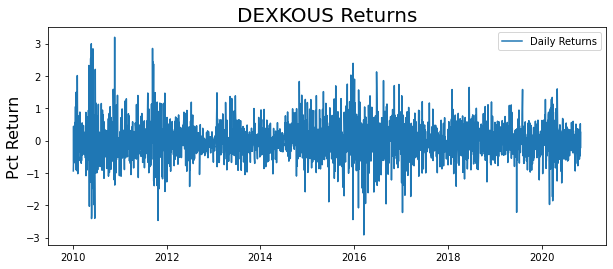

In [3]:
plt.figure(figsize=(10,4))
plt.plot(returns, label='Daily Returns')
plt.ylabel('Pct Return', fontsize=16)
plt.title('DEXKOUS Returns', fontsize=20)
plt.legend(loc='upper right')
plt.show()

Can find the **clustering volatility** where the lower volatility is followed by other lower volatility and vice versa



In [5]:
vol_daily = returns.std()
print('Daily volatility: ', '{:.2f}%'.format(vol_daily))

Daily volatility:  0.55%


Get partial autocorrelation coefficient

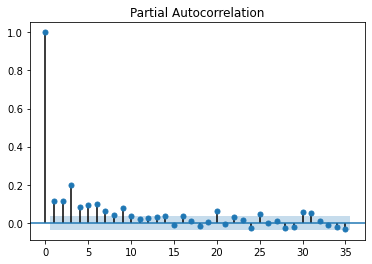

In [6]:
plot_pacf(returns**2)
plt.show()

According to partial autocorrelation graph, pacf of lag 3 has relatively high correlation to measure current residual variance directly 

## Summaries of the Models

- **GARCH**
- **EGARCH**
- **GJR-GARCH**

In [7]:
gm = arch_model(returns, p=3, q=3, dist='normal')

In [8]:
gm_res = gm.fit(disp='off')
gm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                DEXKOUS   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -2093.62
Distribution:                  Normal   AIC:                           4203.23
Method:            Maximum Likelihood   BIC:                           4250.80
                                        No. Observations:                 2824
Date:                Tue, Nov 10 2020   Df Residuals:                     2816
Time:                        03:10:12   Df Model:                            8
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0125  8.916e-03     -1.400      0.161 [-2.996e-02,4.990e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.7368e-03  2.723e-03      2.474  1.334e-02  [1.401e-03,1.207e-02]
alpha[1]       0.0608  2.551e-02      2.383  1.719e-02    [1.078e-02,  0.111]
alpha[2]   3.0917e-03  1.195e-02      0.259      0.796 [-2.033e-02,2.652e-02]
alpha[3]       0.0668  2.848e-02      2.347  1.894e-02    [1.101e-02,  0.123]
beta[1]        0.1243      0.109      1.138      0.255   [-8.970e-02,  0.338]
beta[2]    2.1678e-17      0.207  1.049e-16      1.000      [ -0.405,  0.405]
beta[3]        0.7240      0.165      4.382  1.174e-05      [  0.400,  1.048]
=============================================================================

Covariance estimator: robust
"""

In [19]:
gm_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 322.1775
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x22d99204f70

To see if there is ARCH effect, I used ARCH Lagrange Multiplier test.
According to the p-value of the result, it indicates that there is strong evidence of rejecting null hypothesis, which is residuals are homoskedastic.
Hence, the model has ARCH effect

EGARCH Model fit

In [9]:
egm = arch_model(returns, p=1, q=1, o=1, vol='egarch')

In [10]:
egm_res = egm.fit(disp='off')
egm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                DEXKOUS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2086.58
Distribution:                  Normal   AIC:                           4183.17
Method:            Maximum Likelihood   BIC:                           4212.90
                                        No. Observations:                 2824
Date:                Tue, Nov 10 2020   Df Residuals:                     2819
Time:                        03:10:12   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3424e-03  8.638e-03      0.271      0.786 [-1.459e-02,1.927e-02]
                                Volatility Model                               
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
omega      -9.7086e-03  4.661e-03     -2.083  3.728e-02 [-1.885e-02,-5.723e-04]
alpha[1]        0.0824  1.658e-02      4.969  6.735e-07     [4.989e-02,  0.115]
gamma[1]        0.0594  1.144e-02      5.196  2.038e-07   [3.701e-02,8.184e-02]
beta[1]         0.9895  3.485e-03    283.904      0.000       [  0.983,  0.996]
===============================================================================

Covariance estimator: robust
"""

In [20]:
egm_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 319.8576
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x22d90e7cbe0

The EGARCH model also shows the powerful p-value.
Again, I confirmed that the ARCH effect exists

GJR-GARCH fit

In [11]:
gjr = arch_model(returns, p=1, q=1, o=1,vol = 'garch')
gjr_res = gjr.fit(disp='off')
gjr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                DEXKOUS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2084.93
Distribution:                  Normal   AIC:                           4179.85
Method:            Maximum Likelihood   BIC:                           4209.58
                                        No. Observations:                 2824
Date:                Tue, Nov 10 2020   Df Residuals:                     2819
Time:                        03:10:12   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0595e-03  8.754e-03     -0.349      0.727 [-2.022e-02,1.410e-02]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      1.8007e-03  7.387e-04      2.438  1.479e-02   [3.528e-04,3.248e-03]
alpha[1]       0.0654  1.011e-02      6.474  9.575e-11   [4.563e-02,8.525e-02]
gamma[1]      -0.0577  1.199e-02     -4.814  1.482e-06 [-8.122e-02,-3.422e-02]
beta[1]        0.9569  7.692e-03    124.395      0.000       [  0.942,  0.972]
==============================================================================

Covariance estimator: robust
"""

In [21]:
gjr_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 320.7493
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x22d9923e760

Same as GJR-GARCH model

To summarise so far, I testified two preconditions for modeling GARCH models. The preconditions are the presence of clustering volatility and ARCH effect.


Plot all of the models to compare with the actual returns

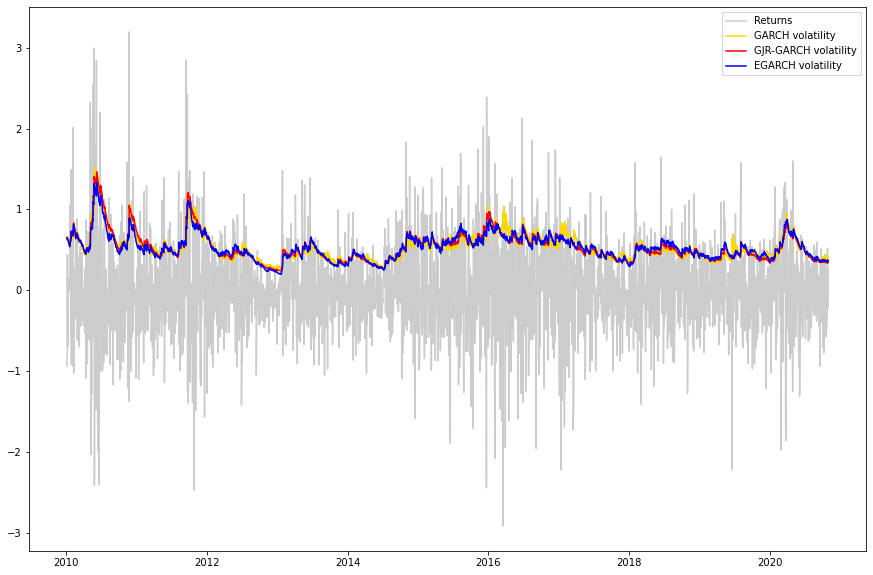

In [22]:
plt.figure(figsize=(15,10))
plt.plot(returns, color='grey', alpha=0.4, label = 'Returns')
plt.plot(gm_res.conditional_volatility, color = 'gold', label = 'GARCH volatility')
plt.plot(gjr_res.conditional_volatility, color='red', label = 'GJR-GARCH volatility')
plt.plot(egm_res.conditional_volatility, color='blue', label = 'EGARCH volatility')

plt.legend(loc = 'upper right')
plt.show()

## Forecasting with the models

Forecast the volatility of DEXKOUS with them using Recursive forecast generation method. 
To evaluate, I used Mean Squared Error(MSE) and Mean Absolute Error (MAE)

First one is GARCH(3,3) model 

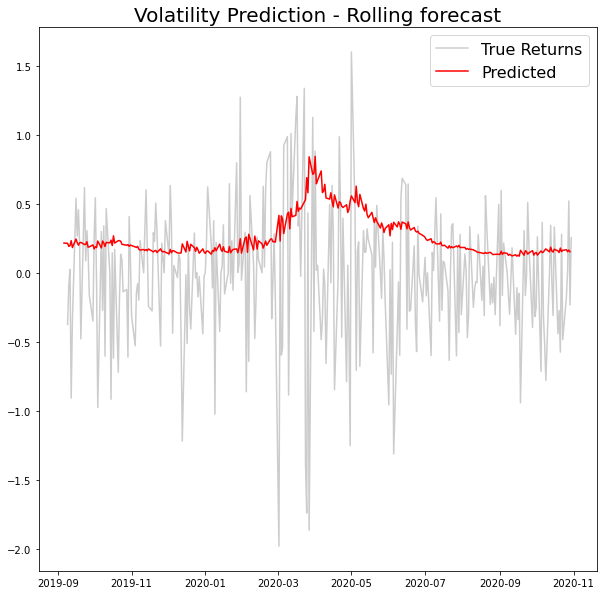

Mean squared error: 0.334
Mean absolute error: 0.427


In [13]:
rolling_predictions = {}
test_size = 300
end_loc = len(returns)-test_size
train = 0
for i in range(test_size):
    train = returns[:-(test_size-i)]
    gm = arch_model(train, p=3, q=3)
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T

plt.figure(figsize=(10,10))
plt.plot(returns[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted'], fontsize=16)
plt.show()

mse = mean_squared_error(returns[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse))

mae = mean_absolute_error(returns[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae))


The following model is EGARCH(1,1) model

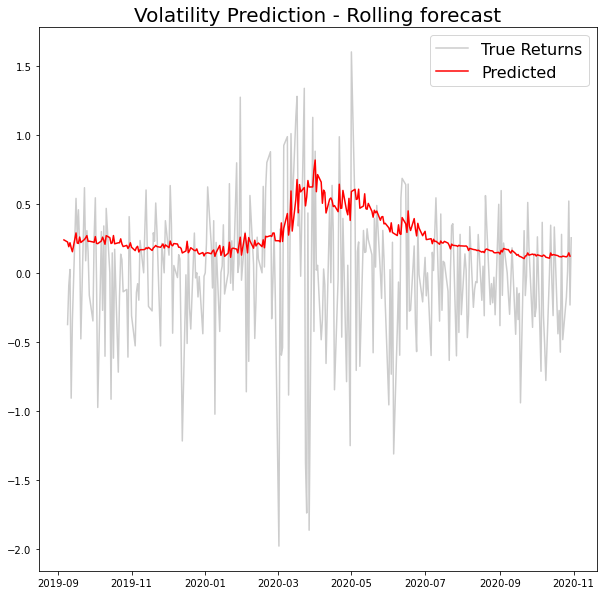

Mean squared error: 0.344
Mean absolute error: 0.435


In [14]:
rolling_predictions = {}

for i in range(test_size):
    train = returns[:-(test_size-i)]
    gm = arch_model(train, p=3, q=3,o=1, vol='egarch')
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T

plt.figure(figsize=(10,10))
plt.plot(returns[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted'], fontsize=16)
plt.show()

mse = mean_squared_error(returns[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse))

mae = mean_absolute_error(returns[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae))


The last one is GJR-GARCH(1,1) model

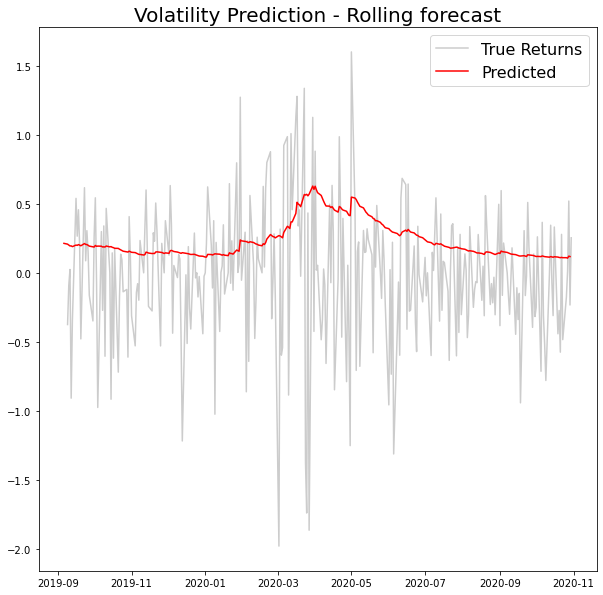

Mean squared error: 0.324
Mean absolute error: 0.419


In [15]:
rolling_predictions = {}

for i in range(test_size):
    train = returns[:-(test_size-i)]
    gm = arch_model(train, p=1, q=1,o=1)
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T
plt.figure(figsize=(10,10))
plt.plot(returns[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted'], fontsize=16)
plt.show()

mse = mean_squared_error(returns[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse))

mae = mean_absolute_error(returns[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae))
